In [ ]:
import pandas as pd
file_path = "/content/log_returns.csv"
df = pd.read_csv(file_path, index_col=0, parse_dates=True)
df.head(), df.columns

(             INFY.NS   SBIN.NS
 Date                          
 2000-05-29       NaN       NaN
 2000-05-30  0.061805  0.031197
 2000-05-31  0.110442  0.025846
 2000-06-01 -0.000729 -0.022328
 2000-06-02  0.074450  0.013704,
 Index(['INFY.NS', 'SBIN.NS'], dtype='object'))

In [ ]:
df=df.dropna(axis=0)
df=df*100

In [ ]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 2.6 MB/s eta 0:00:00


In [ ]:
split_date = "2020-04-26"

# Split the dataset
train_df = df[df.index > split_date]
test_df = df[df.index >= split_date]

# Display the number of rows in each set and the date ranges
train_df.shape, test_df.shape, train_df.index[[0, -1]], test_df.index[[0, -1]]

((1260, 2),
 (1260, 2),
 DatetimeIndex(['2020-04-27', '2025-05-27'], dtype='datetime64[ns]', name='Date', freq=None),
 DatetimeIndex(['2020-04-27', '2025-05-27'], dtype='datetime64[ns]', name='Date', freq=None))

In [ ]:
import pandas as pd
from arch import arch_model
import numpy as np

In [ ]:
def standardresiduals(returns):
    import pandas as pd

    import numpy as np

    standardized_resid_dict = {}
    model_info = {}
    mu_t = {}
    sigma_t = {}

    for stock in train_df.columns:

        try:
            model = arch_model(returns[stock], vol='GARCH',o=1, p=1, q=1,
                              dist='t', mean='ARX', lags=1, rescale=True)
            result = model.fit(disp="off")

            ar_param = f"{stock}[1]"
            mu = result.params['Const'] + result.params[ar_param] * returns[stock].shift(1)
            sigma = result.conditional_volatility

            #mu_t[stock] = mu
            #sigma_t[stock] = sigma
            standardized_resid_dict[stock] = result.std_resid


            # Parameters for simulation
            params = result.params

            #nu=params['nu']

            const_mu = params['Const']
            phi_1 = params[ar_param]


            omega = params['omega']
            alpha = params['alpha[1]']
            gamma = params['gamma[1]']
            beta = params['beta[1]']
            r_t = returns[stock].iloc[-1]
            mu_tt = mu.iloc[-1]
            sigma_tt = sigma.iloc[-1]
            mu_t_plus_1 = const_mu + phi_1 * r_t
            epsilon_t = r_t - mu_tt
            indicator = 1.0 if epsilon_t < 0 else 0.0  # GJR indicator
            sigma_t_plus_1 = np.sqrt(max(omega + alpha * epsilon_t**2 +
                                    beta * sigma_tt**2 +
                                    gamma * indicator * epsilon_t**2,1e-10))
            mu_t[stock] = mu_t_plus_1
            sigma_t[stock] = sigma_t_plus_1
            #model_info[stock



            #model_info[stock] = {
              # 'const_mu': const_mu,
              # 'phi_1': phi_1,
              # 'omega': omega,
                #'alpha': alpha,
                #'beta': beta,
                #'r_t': r_t,
                #'mu_tt': mu_tt,
                #'gamma' : gamma,
                #'sigma_tt': sigma_tt
            #}

        except Exception as e:
            print(f"Model failed for {stock}: {e}")
    return standardized_resid_dict,mu_t,sigma_t


In [ ]:
def thresholdselection(data):
        import numpy as np
        import pandas as pd
        from scipy.stats import genpareto, kstest

        def anderson_darling_statistic(data, c, scale):
            data_sorted = np.sort(data)
            n = len(data_sorted)
            cdf_vals = genpareto.cdf(data_sorted, c, loc=0, scale=scale)
            cdf_vals = np.clip(cdf_vals, 1e-8, 1-1e-8)
            i = np.arange(1, n+1)
            ad_stat = -n - np.sum((2*i - 1) * (np.log(cdf_vals) + np.log(1 - cdf_vals[::-1])) / n)
            return ad_stat

        def bootstrap_ad_pvalue(exceedances, c, scale, n_bootstrap=300, random_state=None):
            if random_state is not None:
                np.random.seed(random_state)
            n = len(exceedances)
            obs_ad = anderson_darling_statistic(exceedances, c, scale)
            boot_stats = []
            for _ in range(n_bootstrap):
                sim_data = genpareto.rvs(c, loc=0, scale=scale, size=n)
                stat = anderson_darling_statistic(sim_data, c, scale)
                boot_stats.append(stat)
            p_value = np.mean(np.array(boot_stats) > obs_ad)
            return p_value

        def auto_gpd_threshold(
            data,
            tail='upper',
            percentiles=np.linspace(80, 99.5, 40),
            min_exceedances=100,
            significance_level=0.05,
            n_bootstrap=300,
            random_state=None
        ):
            """
            Fully automated GPD threshold selection.
            Returns: dict with threshold, shape, scale, p-values, and number of exceedances.
            """
            data = np.asarray(data)
            if tail == 'lower':
                data = -data
                sign = -1
            else:
                sign = 1

            thresholds = np.percentile(data, percentiles)
            results = []
            for u in thresholds:
                    exceedances = data[data > u] - u

                    xi, loc, sigma = genpareto.fit(exceedances, floc=0)
                    ks_stat, ks_p = kstest(exceedances, 'genpareto', args=(xi, loc, sigma))
                    ad_p = bootstrap_ad_pvalue(exceedances, xi, sigma, n_bootstrap=n_bootstrap, random_state=random_state)
                    results.append({
                        "Threshold (u)": sign*u,
                        "Shape": xi,
                        "Scale": sigma,
                        'Loc':loc,
                        "KS_p": ks_p,
                        "AD_p": ad_p,
                        "Num_Exceedances": len(exceedances)
                    })

            if not results:
                raise ValueError("No valid thresholds found.")

            df = pd.DataFrame(results)

            # Statistically valid rows
            valid = df[
                (df["KS_p"] > significance_level) &
                (df["AD_p"] > significance_level) &
                (df["Shape"] > 0)
            ]

            if not valid.empty:
                # Case 1: valid thresholds exist
                if (valid["Num_Exceedances"] >= 100).any():
                    # Pick one with max exceedances among those with ≥ 100
                    best_row = valid[valid["Num_Exceedances"] >= 100].sort_values("Num_Exceedances", ascending=False).iloc[0]
                    a[stock]=a[stock]+1
                    fallback=False
                else:
                    # No threshold has ≥ 100, fallback to highest exceedance among valid
                    print("⚠️ Warning: All valid thresholds have <100 exceedances. Using max among valid.")
                    best_row = valid.sort_values("Num_Exceedances", ascending=False).iloc[0]
                    b[stock]=b[stock]+1
                    fallback=True
            else:
                # No statistically valid thresholds, use fallback
                print("⚠️ Warning: No thresholds passed all statistical tests. Using best available based on exceedances.")
                best_row = df.sort_values("Num_Exceedances", ascending=False).iloc[0]
                c[stock]=c[stock]+1
                fallback=True

            best_row["Fallback"] = fallback
            return best_row.to_dict()

        # For all stocks:
        thresholds_summary = []
        for stock in standardized_resid_df.columns:

            for tail in ['upper', 'lower']:
                try:
                    data = standardized_resid_df[stock].dropna().values
                    result = auto_gpd_threshold(data, tail=tail)
                    result.update({"Stock": stock, "Tail": tail})
                    thresholds_summary.append(result)
                except Exception as e:
                    print(f"Failed for {stock} – {tail} tail: {e}")
        return thresholds_summary


In [ ]:
def pitformation(df):
    import pandas as pd
    import numpy as np
    from scipy.stats import genpareto, gaussian_kde
    import warnings

    warnings.filterwarnings("ignore")

    uniform_transformed = {}

    for stock in df.columns:
        resid = df[stock].dropna().values

        # --- Get GPD parameters from table ---
        lower_row = gpd_df.query("Stock == @stock and Tail == 'lower'").iloc[0]
        upper_row = gpd_df.query("Stock == @stock and Tail == 'upper'").iloc[0]

        lower_thresh = lower_row["Threshold (u)"]
        upper_thresh = upper_row["Threshold (u)"]
        params_lower = (lower_row["Shape"], lower_row["Loc"], lower_row["Scale"])
        params_upper = (upper_row["Shape"], upper_row["Loc"], upper_row["Scale"])

        # Fallback flags
        lower_fallback = lower_row.get("Fallback", False)
        upper_fallback = upper_row.get("Fallback", False)

        n_total = len(resid)

        # --- Probability mass computation ---
        p_lower = len(resid[resid < lower_thresh]) / n_total if not lower_fallback else 0
        p_upper = len(resid[resid > upper_thresh]) / n_total if not upper_fallback else 0
        p_kde   = 1.0 - (p_lower + p_upper)  # KDE covers the rest
        p_center = p_kde  # if both GPDs succeed

        # --- KDE fit ---
        if lower_fallback and not upper_fallback:
            kde_data = resid[resid <= upper_thresh]
        elif not lower_fallback and upper_fallback:
            kde_data = resid[resid >= lower_thresh]
        elif not lower_fallback and not upper_fallback:
            kde_data = resid[(resid >= lower_thresh) & (resid <= upper_thresh)]
        else:
            kde_data = resid

        kde = gaussian_kde(kde_data)
        kde_domain_min = kde_data.min()

        # --- Hybrid CDF ---
        def hybrid_cdf(x):
            if lower_fallback and not upper_fallback:
                if x > upper_thresh:
                    z = x - upper_thresh
                    cdf_tail = genpareto.cdf(z, c=params_upper[0], loc=0, scale=params_upper[2])
                    return 1.0 - p_upper * (1 - cdf_tail)
                else:
                    return p_kde * kde.integrate_box_1d(kde_domain_min, x)

            elif not lower_fallback and upper_fallback:
                if x < lower_thresh:
                    z = lower_thresh - x
                    cdf_tail = genpareto.cdf(z, c=params_lower[0], loc=0, scale=params_lower[2])
                    return p_lower * (1 - cdf_tail)
                else:
                    return p_lower + p_kde * kde.integrate_box_1d(kde_domain_min, x)

            elif not lower_fallback and not upper_fallback:
                if x < lower_thresh:
                    z = lower_thresh - x
                    cdf_tail = genpareto.cdf(z, c=params_lower[0], loc=0, scale=params_lower[2])
                    return p_lower * (1 - cdf_tail)
                elif x > upper_thresh:
                    z = x - upper_thresh
                    cdf_tail = genpareto.cdf(z, c=params_upper[0], loc=0, scale=params_upper[2])
                    return 1.0 - p_upper * (1 - cdf_tail)
                else:
                    return p_lower + p_center * kde.integrate_box_1d(kde_domain_min, x)

            else:
                # Both failed → full KDE
                return kde.integrate_box_1d(kde_domain_min, x)

        # --- Apply CDF to residuals ---
        pit_vals = np.array([hybrid_cdf(x) for x in resid])
        uniform_transformed[stock] = pit_vals

    return uniform_transformed


In [ ]:
pip install copulae

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 5.6 MB/s eta 0:00:00


In [ ]:
!pip install pyvinecopulib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.4 MB/s eta 0:00:00


In [ ]:
def hill_estimator_exceedances(data, threshold, side='right'):
    """
    Compute Hill estimator ξ from exceedances over a threshold.

    Parameters:
    - data: pd.Series or 1D array
    - threshold: float, threshold to define exceedances
    - side: 'right' for upper tail, 'left' for lower tail

    Returns:
    - xi: Hill estimator ξ
    - implied_df: Implied degrees of freedom (≈ 1/ξ)
    - num_exceed: Number of exceedances used
    """
    x = np.asarray(data.dropna())

    if side == 'left':
        x = -x
        threshold = -threshold

    exceedances = x[x > threshold]
    num_exceed = len(exceedances)

    if num_exceed < 2:
        raise ValueError("Not enough exceedances to compute Hill estimator.")

    exceedances = np.sort(exceedances)[::-1]  # descending
    logs = np.log(exceedances) - np.log(exceedances[-1])
    hill_xi = np.mean(logs)
    implied_df = 1 / hill_xi if hill_xi > 0 else np.inf

    return hill_xi, implied_df, num_exceed


In [ ]:
def inverse(data, gpd_df):
    import numpy as np
    from scipy.stats import genpareto, gaussian_kde
    from scipy.interpolate import interp1d

    inverse_cdf_funcs = {}

    for stock in data.columns:
        resid = data[stock].dropna().values

        # Load GPD parameters
        lower_row = gpd_df.query("Stock == @stock and Tail == 'lower'").iloc[0]
        upper_row = gpd_df.query("Stock == @stock and Tail == 'upper'").iloc[0]

        lower_thresh = lower_row["Threshold (u)"]
        upper_thresh = upper_row["Threshold (u)"]
        params_lower = (lower_row["Shape"], lower_row["Loc"], lower_row["Scale"])
        params_upper = (upper_row["Shape"], upper_row["Loc"], upper_row["Scale"])

        lower_fallback = lower_row.get("Fallback", False)
        upper_fallback = upper_row.get("Fallback", False)

        # Define KDE region based on which tail(s) failed
        if lower_fallback and not upper_fallback:
            kde_data = resid[resid <= upper_thresh]
        elif not lower_fallback and upper_fallback:
            kde_data = resid[resid >= lower_thresh]
        elif lower_fallback and upper_fallback:
            kde_data = resid
        else:
            kde_data = resid[(resid >= lower_thresh) & (resid <= upper_thresh)]

        kde = gaussian_kde(kde_data)
        kde_domain_min = kde_data.min()
        kde_domain_max = kde_data.max()

        # Empirical probabilities
        if lower_fallback and not upper_fallback:
            p_kde = len(kde_data) / len(resid)
            p_upper = len(resid[resid > upper_thresh]) / len(resid)
        elif not lower_fallback and upper_fallback:
            p_lower = len(resid[resid < lower_thresh]) / len(resid)
            p_kde = len(kde_data) / len(resid)
        elif lower_fallback and upper_fallback:
            p_kde = 1.0
        else:
            lower_tail = resid[resid < lower_thresh]
            upper_tail = resid[resid > upper_thresh]
            center = resid[(resid >= lower_thresh) & (resid <= upper_thresh)]
            p_lower = len(lower_tail) / len(resid)
            p_upper = len(upper_tail) / len(resid)
            p_center = 1.0 - (p_lower + p_upper)
            p_kde=p_center

        # Precompute inverse KDE interpolant
        grid = np.linspace(kde_domain_min, kde_domain_max, 500)
        cdf_vals = np.array([kde.integrate_box_1d(kde_domain_min, x) for x in grid])
        inv_kde = interp1d(cdf_vals, grid, bounds_error=False, fill_value=(grid[0], grid[-1]))

        # Construct inverse function
        def make_inverse_cdf(lower_thresh, upper_thresh, params_lower, params_upper,
                             inv_kde, lower_fallback, upper_fallback,
                             p_lower=0, p_upper=0, p_center=0, p_kde=1.0):
            def hybrid_ppf(u_array):
                u_array = np.asarray(u_array)
                result = np.empty_like(u_array)

                if lower_fallback and not upper_fallback:
                    upper_mask = u_array > (1.0 - p_upper)
                    kde_mask = ~upper_mask

                    result[upper_mask] = upper_thresh + genpareto.ppf(
                        (u_array[upper_mask] - (1.0 - p_upper)) / p_upper, *params_upper
                    )
                    result[kde_mask] = inv_kde(u_array[kde_mask] / p_kde)

                elif not lower_fallback and upper_fallback:
                    lower_mask = u_array < p_lower
                    kde_mask = ~lower_mask

                    q = 1.0 - (u_array[lower_mask] / p_lower)
                    result[lower_mask] = lower_thresh - genpareto.ppf(q, *params_lower)
                    result[kde_mask] = inv_kde((u_array[kde_mask] - p_lower) / p_kde)

                elif not lower_fallback and not upper_fallback:
                    lower_mask = u_array < p_lower
                    upper_mask = u_array > (1.0 - p_upper)
                    center_mask = ~(lower_mask | upper_mask)

                    q = 1.0 - (u_array[lower_mask] / p_lower)
                    result[lower_mask] = lower_thresh - genpareto.ppf(q, *params_lower)

                    result[upper_mask] = upper_thresh + genpareto.ppf(
                        (u_array[upper_mask] - (1.0 - p_upper)) / p_upper, *params_upper
                    )
                    result[center_mask] = inv_kde((u_array[center_mask] - p_lower) / p_center)

                else:
                    result[:] = inv_kde(u_array)

                return result

            return hybrid_ppf

        # Assign final inverse function
        inverse_cdf_funcs[stock] = make_inverse_cdf(
            lower_thresh, upper_thresh,
            params_lower, params_upper,
            inv_kde,
            lower_fallback, upper_fallback,
            p_lower if 'p_lower' in locals() else 0.0,
            p_upper if 'p_upper' in locals() else 0.0,
            p_center if 'p_center' in locals() else 0.0,
            p_kde

        )

    return inverse_cdf_funcs

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import t

# Assume test_df is your test set DataFrame (dates as index, columns as asset returns)
# Assume model_info is a dict with keys as stock names and values as dicts containing 'mu_tt', 'sigma_tt', 'nu'

window_size = 1000
step_size = 1
var_level = 0.05
weights = np.array([0.5, 0.5])  # Adjust as needed
stock_names = train_df.columns.tolist()
actual_returns=[]
dates=[]
var_results = []

es_results=[]
a={}
b={}
c={}

for i in stock_names:
  a[i]=0
  b[i]=0
  c[i]=0


hill_summary = []
for start in range(0, len(train_df) - window_size + 1, step_size):
    end = start + window_size
    window_returns = train_df.iloc[start:end]
    window_date = window_returns.index[-1]
    # Actual portfolio return for the last day of the window
    actual_ret = (window_returns.iloc[-1] @ weights)
    actual_returns.append(actual_ret)
    dates.append(window_date)
    # For each stock, get the last mu and sigma from model_info (update this if you re-fit per window)
    returns=window_returns.iloc[:-1]
    standardized_resid_dict,mu_t,sigma_t=standardresiduals(returns)
    # Save residuals
    standardized_resid_df = pd.DataFrame(standardized_resid_dict).iloc[1:]
    standardized_resid_df.to_csv("standardized_residuals.csv")
    print("Finished! Standardized residuals saved to 'standardized_residuals.csv'")

    thresholds_summary=thresholdselection(standardized_resid_df)
    gpd_df = pd.DataFrame(thresholds_summary)
    gpd_df.to_csv("automated_gpd_thresholds.csv", index=False)
    print("✅ Thresholds and GPD params saved to 'automated_gpd_thresholds.csv'")


    for stock in standardized_resid_df.columns:
        resid = standardized_resid_df[stock].dropna()

        try:
            # --- Right Tail ---
            threshol_r = gpd_df.query("Stock == @stock and Tail == 'upper'").iloc[0]
            threshold_r = threshol_r["Threshold (u)"]
            upper_fallback = threshol_r.get("Fallback", False)

            if not upper_fallback:
                xi_right, df_right, n_exceed_r = hill_estimator_exceedances(resid, threshold_r, side='right')
            else:
                xi_right = df_right = n_exceed_r = None

            # --- Left Tail ---
            threshol_l = gpd_df.query("Stock == @stock and Tail == 'lower'").iloc[0]
            threshold_l = threshol_l["Threshold (u)"]
            lower_fallback = threshol_l.get("Fallback", False)

            if not lower_fallback:
                xi_left, df_left, n_exceed_l = hill_estimator_exceedances(resid, threshold_l, side='left')
            else:
                xi_left = df_left = n_exceed_l = None

            # Store results safely
            hill_summary.append({
                "Stock": stock,
                "Date": window_date,
                "Hill_xi_right": xi_right,
                "Implied_df_right": df_right,
                "Exceedances_right": n_exceed_r,
                "Threshold_right": threshold_r,
                "Hill_xi_left": xi_left,
                "Implied_df_left": df_left,
                "Exceedances_left": n_exceed_l,
                "Threshold_left": threshold_l
            })

        except Exception as e:
            print(f"❌ Hill estimation failed for {stock}: {e}")
    df = pd.read_csv("standardized_residuals.csv", index_col=0, parse_dates=True)
    df = df.dropna(axis=0)
    uniform_transformed=pitformation(df)
    # --- Save result ---
    pit_df = pd.DataFrame(uniform_transformed, index=df.index)
    pit_df.to_csv("pit_transformed_uniforms.csv")
    print("✅ Done. PIT-transformed values saved to 'pit_transformed_uniforms.csv'")
    import pandas as pd
    import numpy as np
    import pyvinecopulib as pv

    # Load PIT-transformed data

    U = pit_df.to_numpy()

    # Fit a vine copula with only Gaussian pai``1qr-copulas
    controls = pv.FitControlsVinecop(family_set=[pv.BicopFamily.student])
    vine = pv.Vinecop.from_data(U, controls=controls)

    print(vine)
    inverse_cdf_funcs=inverse(standardized_resid_df,gpd_df)
    import pyvinecopulib as pv
    import numpy as np

    n_days = 1        # e.g., 2600
    n_paths = 10000                # number of simulation scenarios
    n_stocks = len(pit_df.columns)
    stock_names = pit_df.columns.tolist()

    # Initialize storage: shape (n_paths, n_days, n_stocks)
    simulated_uniforms = np.zeros((n_paths, n_days, n_stocks))

    # Simulate one scenario at a time
    for path in range(n_paths):
        # Generate all days for this scenario in one go
        scenario = vine.simulate(n_days)  # shape: (n_days, n_stocks)

        # Store into output array
        simulated_uniforms[path, :, :] = scenario
    n_paths, n_days, n_stocks = simulated_uniforms.shape
    simulated_residuals = np.zeros_like(simulated_uniforms)

    for j, stock in enumerate(pit_df.columns):
        inv_func = inverse_cdf_funcs[stock]

        # Flatten, apply, and reshape back
        flat_uniforms = simulated_uniforms[:, :, j].reshape(-1)
        flat_residuals = inv_func(flat_uniforms)
        simulated_residuals[:, :, j] = flat_residuals.reshape(n_paths, n_days)
    simulated_returns = np.zeros_like(simulated_residuals)




    for stock_idx, stock in enumerate(stock_names):
        for path in range(n_paths):


            # ✅ Normalize the entire residual sequence once for this stock/path
            z_seq = simulated_residuals[path, :, stock_idx]


            for t in range(n_days):
                z_t = z_seq[t]
                r_t_new = mu_t[stock] + sigma_t[stock] * z_t
                simulated_returns[path, t, stock_idx] = r_t_new
    portfolio_returns = np.einsum('ijk,k->ij', simulated_returns, weights)

    # Step 2: Compute daily VaR at 1% level (or 5%)
    var_level = 0.05  # Change to 0.05 for 5% VaR
    daily_var = np.quantile(portfolio_returns, var_level, axis=0)
    var_results.append(daily_var)

    expected_shortfall = portfolio_returns[portfolio_returns < daily_var].mean()

    # Store metrics

    es_results.append(expected_shortfall)







Finished! Standardized residuals saved to 'standardized_residuals.csv'
⚠️ Warning: No thresholds passed all statistical tests. Using best available based on exceedances.
✅ Thresholds and GPD params saved to 'automated_gpd_thresholds.csv'
✅ Done. PIT-transformed values saved to 'pit_transformed_uniforms.csv'
<pyvinecopulib.Vinecop> Vinecop model with 2 variables
tree edge conditioned variables conditioning variables var_types  family rotation  parameters  df  tau 
   1    1                  1, 2                             c, c Student        0 0.19, 36.60 2.0 0.12 

Finished! Standardized residuals saved to 'standardized_residuals.csv'
⚠️ Warning: No thresholds passed all statistical tests. Using best available based on exceedances.
✅ Thresholds and GPD params saved to 'automated_gpd_thresholds.csv'
✅ Done. PIT-transformed values saved to 'pit_transformed_uniforms.csv'
<pyvinecopulib.Vinecop> Vinecop model with 2 variables
tree edge conditioned variables conditioning variables var_type

In [ ]:
hill_summary_df = pd.DataFrame(hill_summary)
hill_summary_df.to_csv("rolling_hill_estimates.csv", index=False)
print("✅ Saved Hill estimates with time tracking to 'rolling_hill_estimates.csv'")

✅ Saved Hill estimates with time tracking to 'rolling_hill_estimates.csv'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load saved Hill estimates (make sure 'Date' is parsed as datetime)
hill_df = pd.read_csv("rolling_hill_estimates.csv", parse_dates=["Date"])

# Sort to ensure chronological plotting
hill_df = hill_df.sort_values(["Stock", "Date"])

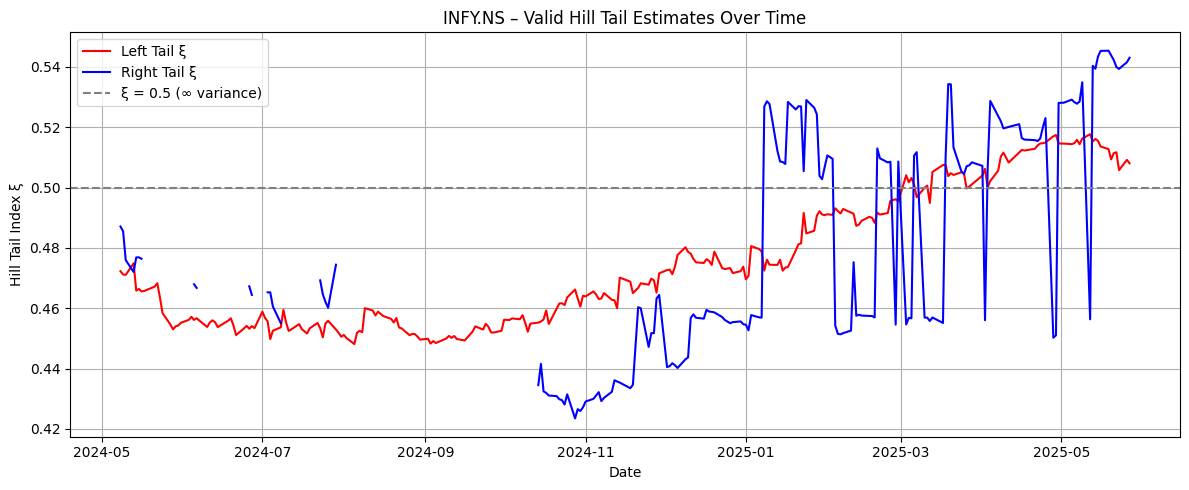

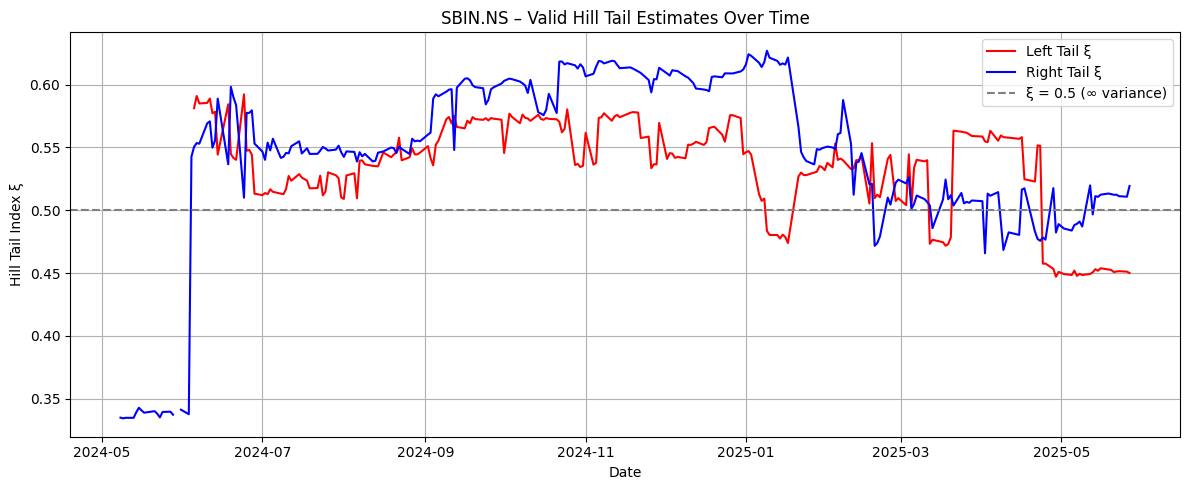

In [ ]:
import matplotlib.pyplot as plt

for stock in hill_df["Stock"].unique():
    stock_data = hill_df[hill_df["Stock"] == stock]

    has_valid_left = stock_data["Hill_xi_left"].notna().any()
    has_valid_right = stock_data["Hill_xi_right"].notna().any()

    # Skip if both tails are invalid
    if not (has_valid_left or has_valid_right):
        continue

    plt.figure(figsize=(12, 5))

    # Plot only valid tails
    if has_valid_left:
        plt.plot(
            stock_data["Date"],
            stock_data["Hill_xi_left"],
            color="red",
            label="Left Tail ξ"
        )

    if has_valid_right:
        plt.plot(
            stock_data["Date"],
            stock_data["Hill_xi_right"],
            color="blue",
            label="Right Tail ξ"
        )

    # Horizontal reference line at ξ = 0.5 (infinite variance)
    plt.axhline(0.5, linestyle="--", color="gray", label="ξ = 0.5 (∞ variance)")

    plt.title(f"{stock} – Valid Hill Tail Estimates Over Time")
    plt.xlabel("Date")
    plt.ylabel("Hill Tail Index ξ")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
print(a['SBIN.NS'],a['INFY.NS'],c['SBIN.NS'],c['INFY.NS'])

501 440 19 0


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2

# 1. Christoffersen Test (Conditional Coverage)
def christoffersen_test(violations):
    v = np.asarray(violations, dtype=int)
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(v)):
        prev, curr = v[i-1], v[i]
        if prev == 0 and curr == 0: n00 += 1
        elif prev == 0 and curr == 1: n01 += 1
        elif prev == 1 and curr == 0: n10 += 1
        elif prev == 1 and curr == 1: n11 += 1

    pi_01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi_11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)

    # Log-likelihood Ratio
    L0 = ((1 - pi) ** (n00 + n10)) * (pi ** (n01 + n11))
    L1 = ((1 - pi_01) ** n00) * (pi_01 ** n01) * ((1 - pi_11) ** n10) * (pi_11 ** n11)
    LR_ind = -2 * np.log(L0 / L1) if L0 > 0 and L1 > 0 else 0
    p_value = 1 - chi2.cdf(LR_ind, df=1)
    return p_value, LR_ind

# 2. Acerbi–Szekely Unconditional ES Test
def es_unconditional_test(X_obs, VaR, ES, VaRLevel=0.05, nSim=10000, alpha=0.05, random_state=None):
    X_obs = np.asarray(X_obs)
    VaR = np.asarray(VaR)
    ES = np.asarray(ES)
    T = len(X_obs)

    if random_state is not None:
        np.random.seed(random_state)

    I = (X_obs < VaR).astype(float)
    stat = (1/(T*VaRLevel)) * np.sum((X_obs * I) / ES) + 1

    sim_stats = []
    for _ in range(nSim):
        U = np.random.uniform(size=T)
        X_sim = np.where(U < VaRLevel, ES, VaR)
        I_sim = (X_sim < VaR).astype(float)
        sim_stat = (1/(T*VaRLevel)) * np.sum((X_sim * I_sim) / ES) + 1
        sim_stats.append(sim_stat)

    sim_stats = np.array(sim_stats)
    crit_val = np.percentile(sim_stats, 100 * alpha)
    crit_val2=np.percentile(sim_stats,100*(1-alpha))
    p_value = np.mean(sim_stats <= stat)
    p_value2=np.mean(sim_stats>=stat)

    return stat, crit_val, p_value,crit_val2,p_value2

# 3. Full Backtest Function
def backtest_var_es(actual_returns,
                    var_series,
                    es_series,
                    var_level=0.05,
                    nSim=10000):
    """
    Backtest VaR and ES using Kupiec, Christoffersen, and Acerbi–Szekely tests.
    Inputs: np.ndarray or list for all arguments.
    """
    actual_returns = np.asarray(actual_returns)
    var_series = np.asarray(var_series)
    es_series = np.asarray(es_series)

    # 1. VaR Violations
    violations = actual_returns < var_series
    n_violations = violations.sum()
    n = len(actual_returns)

    # 2. Kupiec Test (Unconditional Coverage)
    count = n_violations
    kupiec_stat, kupiec_p = proportions_ztest(count, n, value=var_level)

    # 3. Christoffersen Test (Conditional Coverage)
    christ_p, christ_stat = christoffersen_test(violations)

    # 4. ES Accuracy (Acerbi–Szekely Unconditional Test)
    es_stat, es_crit, es_p,crit_val2,p_value2 = es_unconditional_test(
        X_obs=actual_returns,
        VaR=var_series,
        ES=es_series,
        VaRLevel=var_level,
        nSim=nSim
    )

    # 5. Mean Absolute ES Error (for violations)
    actual_losses = actual_returns[violations]
    es_predicted = es_series[violations]
    empirical_es_loss = actual_returns[violations].mean()
    mae_es = np.abs(actual_losses - es_predicted).mean()
    empirical_es_loss = actual_returns[violations].mean()
    empirical_es_loss_percent = (np.exp(empirical_es_loss/100) - 1) * 100
    print(f"Empirical ES in %: {empirical_es_loss_percent:.2f}%")

    # Print results
    print(f"\n📊 Backtest Results (VaR Level: {int(var_level * 100)}%)")
    print(f"-------------------------------------------")
    print(f"VaR violations:              {n_violations} / {n} ({n_violations/n:.2%})")
    print(f"Kupiec Test p-value:         {kupiec_p:.4f}")
    print(f"Christoffersen p-value:      {christ_p:.4f}")
    print(f"Acerbi–Szekely ES stat:      {es_stat:.4f}")
    print(f"Acerbi–Szekely crit value:   {es_crit:.4f}")
    print(f"Acerbi–Szekely ES p-value:   {es_p:.4f}")
    print(f"Mean Absolute ES Error:      {mae_es:.4f}")
    print(f"Empirical ES in % : {empirical_es_loss_percent:.2f}%,critical value 95% : {crit_val2}, p value right : {p_value2}")

    return {
        "kupiec_p": kupiec_p,
        "christoffersen_p": christ_p,
        "acerbi_szekely_stat": es_stat,
        "acerbi_szekely_crit": es_crit,
        "acerbi_szekely_p": es_p,
        "mae_es": mae_es,
        "empirical_es_loss_percent": empirical_es_loss_percent
    }


In [ ]:
var_results = [float(x[0]) if isinstance(x, (np.ndarray, list)) else float(x) for x in var_results]
es_results = [float(x[0]) if isinstance(x, (np.ndarray, list)) else float(x) for x in es_results]
var_es_df = pd.DataFrame({
    "Date": dates,
    "Actual": actual_returns,
    "VaR_5%": var_results,
    "ES_5%": es_results
})
var_es_df.set_index("Date", inplace=True)

In [ ]:
import numpy as np



backtest_var_es(
    actual_returns = var_es_df["Actual"].values,
    var_series     = var_es_df["VaR_5%"].values,
    es_series      = var_es_df["ES_5%"].values,
    var_level      = 0.05
      # or 5000 if faster execution needed
)

Empirical ES in %: -3.12%

📊 Backtest Results (VaR Level: 5%)
-------------------------------------------
VaR violations:              12 / 261 (4.60%)
Kupiec Test p-value:         0.7563
Christoffersen p-value:      0.5683
Acerbi–Szekely ES stat:      2.0899
Acerbi–Szekely crit value:   1.6130
Acerbi–Szekely ES p-value:   0.6708
Mean Absolute ES Error:      1.0589
Empirical ES in % : -3.12%,critical value 95% : 2.4559386973180075, p value right : 0.3292


{'kupiec_p': np.float64(0.7563124676489766),
 'christoffersen_p': np.float64(0.5683140243226963),
 'acerbi_szekely_stat': np.float64(2.0898940785563194),
 'acerbi_szekely_crit': np.float64(1.6130268199233715),
 'acerbi_szekely_p': np.float64(0.6708),
 'mae_es': np.float64(1.0589301880843436),
 'empirical_es_loss_percent': np.float64(-3.118326646435554)}

In [ ]:
print(var_es_df[["VaR_5%", "ES_5%", "Actual"]].applymap(type).head())

                     VaR_5%            ES_5%           Actual
Date                                                         
2024-05-08  <class 'float'>  <class 'float'>  <class 'float'>
2024-05-09  <class 'float'>  <class 'float'>  <class 'float'>
2024-05-10  <class 'float'>  <class 'float'>  <class 'float'>
2024-05-13  <class 'float'>  <class 'float'>  <class 'float'>
2024-05-14  <class 'float'>  <class 'float'>  <class 'float'>


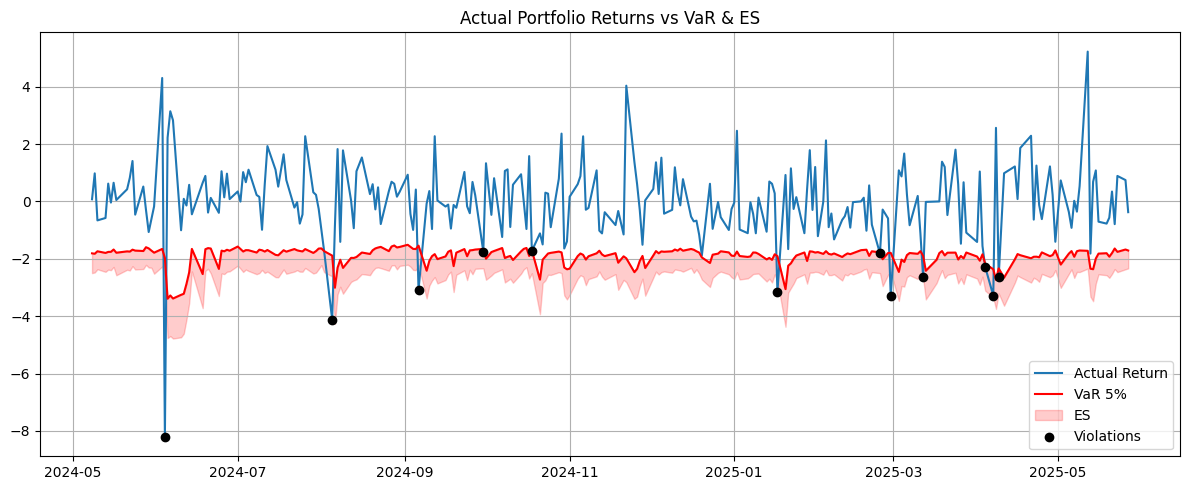

VaR_5%    float64
ES_5%     float64
Actual    float64
dtype: object
              VaR_5%     ES_5%    Actual
Date                                    
2024-05-08 -1.809718 -2.499674  0.075973
2024-05-09 -1.824005 -2.475701  0.979252
2024-05-10 -1.738089 -2.364742 -0.661097
2024-05-13 -1.795106 -2.454829 -0.576695
2024-05-14 -1.759686 -2.378405  0.621644


In [ ]:

import matplotlib.pyplot as plt

violations = var_es_df["Actual"] < var_es_df["VaR_5%"]

plt.figure(figsize=(12, 5))
plt.plot(var_es_df.index, var_es_df["Actual"], label="Actual Return")
plt.plot(var_es_df.index, var_es_df["VaR_5%"], label="VaR 5%", color="red")
plt.fill_between(var_es_df.index, var_es_df["VaR_5%"], var_es_df["ES_5%"],
                 color='red', alpha=0.2, label="ES")
plt.scatter(var_es_df.index[violations], var_es_df["Actual"][violations],
            color="black", label="Violations", zorder=5)
plt.title("Actual Portfolio Returns vs VaR & ES")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(var_es_df[["VaR_5%", "ES_5%", "Actual"]].dtypes)
print(var_es_df[["VaR_5%", "ES_5%", "Actual"]].head())

In [ ]:
print(var_es_df[["VaR_5%", "ES_5%", "Actual"]].dtypes)
print(var_es_df[["VaR_5%", "ES_5%", "Actual"]].head())

VaR_5%    float64
ES_5%     float64
Actual    float64
dtype: object
              VaR_5%     ES_5%    Actual
Date                                    
2024-05-08 -1.809718 -2.499674  0.075973
2024-05-09 -1.824005 -2.475701  0.979252
2024-05-10 -1.738089 -2.364742 -0.661097
2024-05-13 -1.795106 -2.454829 -0.576695
2024-05-14 -1.759686 -2.378405  0.621644
